In [5]:
import os
os.makedirs("/Users/jacobhahn/Desktop/QUANT PROJECT WINTER 2025/week3_outputs", exist_ok=True)
os.makedirs("/Users/jacobhahn/Desktop/QUANT PROJECT WINTER 2025/week3_figures", exist_ok=True)


In [6]:
import numpy as np
import pandas as pd

def get_monthly_rebalance_dates(rets: pd.DataFrame) -> pd.DatetimeIndex:
    return rets.groupby([rets.index.year, rets.index.month]).head(1).index

def rolling_pca_corr(
    rets: pd.DataFrame,
    rebalance_dates: pd.DatetimeIndex,
    W: int = 252,
    K: int = 5,
    orient_ticker: str | None = "SPY"
):
    """
    Rolling PCA on correlation matrix using standardized returns.
    Returns:
      dates_used: DatetimeIndex
      V_list: list of eigenvector matrices (N x N) aligned by sign month-to-month (for first K PCs)
      eigvals: (T x N) array of eigenvalues
    """
    tickers = rets.columns
    N = len(tickers)

    dates_used = []
    V_list = []
    eigvals_list = []
    prev_VK = None  # previous month's first K eigenvectors

    for T in rebalance_dates:
        loc = rets.index.get_indexer([T])[0]
        if loc < W:
            continue
        window = rets.iloc[loc-W:loc]
        X = window - window.mean(axis=0)
        s = X.std(axis=0, ddof=1).replace(0, np.nan)
        Z = (X / s).values  # W x N
        C = (Z.T @ Z) / (len(window) - 1)  # N x N correlation

        w, V = np.linalg.eigh(C)          # ascending
        idx = np.argsort(w)[::-1]
        w = w[idx]
        V = V[:, idx]                      # columns are PCs

        # Align signs for first K PCs to previous month (cosine similarity)
        VK = V[:, :K].copy()
        if prev_VK is not None:
            for k in range(K):
                if np.dot(VK[:, k], prev_VK[:, k]) < 0:
                    VK[:, k] *= -1
            V[:, :K] = VK
        prev_VK = V[:, :K].copy()

        # Optional: orient PC1 so a chosen ticker has positive loading (consistency in writeups)
        if orient_ticker is not None and orient_ticker in tickers:
            j = tickers.get_loc(orient_ticker)
            if V[j, 0] < 0:
                V[:, 0] *= -1

        dates_used.append(T)
        V_list.append(V)
        eigvals_list.append(w)

    return pd.DatetimeIndex(dates_used), V_list, np.array(eigvals_list)

def eigenportfolio_weights(V: np.ndarray, k: int) -> np.ndarray:
    """
    Dollar-neutral eigenportfolio from k-th PC (1-indexed):
      - demean to force sum(w)=0
      - normalize to L1 = 1 (unit gross exposure)
    """
    v = V[:, k-1].copy()
    v = v - v.mean()               # sum approx 0
    l1 = np.sum(np.abs(v))
    return v / l1 if l1 > 0 else v

def solve_minvar_with_constraints(Sigma: np.ndarray, A: np.ndarray, b: np.ndarray, ridge: float = 1e-6) -> np.ndarray:
    """
    Solve: min (1/2) w' Σ w  s.t. A' w = b using KKT system.
    A: (N x m), b: (m,)
    """
    N = Sigma.shape[0]
    m = A.shape[1]
    Sig = Sigma + ridge * np.eye(N)

    KKT = np.block([
        [Sig, A],
        [A.T, np.zeros((m, m))]
    ])
    rhs = np.concatenate([np.zeros(N), b])
    sol = np.linalg.solve(KKT, rhs)
    w = sol[:N]
    return w

def backtest_from_rebalance_weights(
    rets_log: pd.DataFrame,
    w_reb: pd.DataFrame,
    cost_per_turnover: float = 0.001  # 10 bps per 100% turnover
):
    """
    rets_log: daily log returns (T x N)
    w_reb: weights on rebalance dates (R x N), indexed by rebalance dates
    cost applied on rebalance dates: wealth *= (1 - cost_per_turnover * turnover)
    Returns dataframe with gross/net simple returns, wealth, turnover, gross_leverage.
    """
    # Daily weights
    w_daily = w_reb.reindex(rets_log.index).ffill()

    # Gross daily portfolio log returns
    port_log = (w_daily * rets_log).sum(axis=1)
    gross_simple = np.exp(port_log) - 1

    # Turnover on rebalance dates
    w_prev = w_reb.shift(1)
    turnover = (w_reb - w_prev).abs().sum(axis=1)
    turnover.iloc[0] = w_reb.iloc[0].abs().sum()  # entering initial positions

    # Gross leverage on rebalance dates
    gross_lev = w_reb.abs().sum(axis=1)

    # Apply costs to wealth on rebalance days
    wealth_gross = (1 + gross_simple).cumprod()
    wealth_net = []
    net_simple = gross_simple.copy()

    W = 1.0
    reb_set = set(w_reb.index)
    for t in gross_simple.index:
        r = gross_simple.loc[t]
        W = W * (1 + r)
        if t in reb_set:
            tc = cost_per_turnover * turnover.loc[t]
            W = W * (1 - tc)
        wealth_net.append(W)

    wealth_net = pd.Series(wealth_net, index=gross_simple.index, name="wealth_net")
    wealth_gross = wealth_gross.rename("wealth_gross")

    out = pd.DataFrame({
        "gross_simple_ret": gross_simple,
        "wealth_gross": wealth_gross,
        "wealth_net": wealth_net,
    })
    # Put turnover/leverage on daily index (NaN except rebalance dates)
    out["turnover"] = turnover.reindex(out.index)
    out["gross_leverage"] = gross_lev.reindex(out.index)
    return out

def perf_metrics(simple_rets: pd.Series) -> dict:
    """
    simple_rets: daily simple returns
    Uses CAGR for return; annualized vol from daily std; Sharpe rf=0.
    """
    T = len(simple_rets)
    wealth = (1 + simple_rets).cumprod()
    cagr = wealth.iloc[-1]**(252/T) - 1
    vol = simple_rets.std() * np.sqrt(252)
    sharpe = (simple_rets.mean() * 252) / vol if vol > 0 else np.nan
    dd = wealth / wealth.cummax() - 1
    return {
        "CAGR": cagr,
        "AnnVol": vol,
        "Sharpe(rf=0)": sharpe,
        "MaxDD": dd.min()
    }


In [9]:
import pandas as pd
import numpy as np

# Load returns (log returns)
rets = pd.read_csv("/Users/jacobhahn/Desktop/QUANT PROJECT WINTER 2025/data_processed/returns_log.csv", index_col=0, parse_dates=True).sort_index()
tickers = rets.columns
N = len(tickers)

rebalance_dates = get_monthly_rebalance_dates(rets)

W = 252
K_track = 5
dates_used, V_list, eigvals = rolling_pca_corr(rets, rebalance_dates, W=W, K=K_track, orient_ticker="SPY")

# ---------- Eigenportfolio weights (PC1-3) ----------
def build_eigen_weights(pc: int) -> pd.DataFrame:
    rows = []
    for T, V in zip(dates_used, V_list):
        w = eigenportfolio_weights(V, pc)
        rows.append(w)
    return pd.DataFrame(rows, index=dates_used, columns=tickers)

w_pc1 = build_eigen_weights(1)
w_pc2 = build_eigen_weights(2)
w_pc3 = build_eigen_weights(3)

# ---------- Factor-neutral min-variance weights ----------
# Neutralize to top K_neutral PCs (typically 1-2 are most meaningful)
K_neutral = 2

w_fnmv_rows = []
w_minvar_rows = []

ridge = 1e-6  # numerical stability
for T in dates_used:
    loc = rets.index.get_indexer([T])[0]
    window = rets.iloc[loc-W:loc]
    X = window - window.mean(axis=0)
    Sigma = np.cov(X.values, rowvar=False, ddof=1)  # covariance of returns (not standardized)

    # Get V_K from correlation PCA at this date
    V = V_list[dates_used.get_loc(T)]
    VK = V[:, :K_neutral]  # N x K_neutral

    # Constraints:
    # 1) fully invested: 1' w = 1
    # 2) factor-neutral: VK' w = 0  (neutral to those PCs)
    A = np.column_stack([np.ones(N), VK])          # N x (1+K_neutral)
    b = np.concatenate([[1.0], np.zeros(K_neutral)])

    w_fn = solve_minvar_with_constraints(Sigma, A, b, ridge=ridge)
    w_fnmv_rows.append(w_fn)

    # Optional comparator: plain min-var with only 1'w=1
    A0 = np.ones((N,1))
    b0 = np.array([1.0])
    w_mv = solve_minvar_with_constraints(Sigma, A0, b0, ridge=ridge)
    w_minvar_rows.append(w_mv)

w_fnmv = pd.DataFrame(w_fnmv_rows, index=dates_used, columns=tickers)
w_minvar = pd.DataFrame(w_minvar_rows, index=dates_used, columns=tickers)

# Save weights (so you can reference later)
w_pc1.to_csv("/Users/jacobhahn/Desktop/QUANT PROJECT WINTER 2025/weights_eigen_pc1.csv")
w_pc2.to_csv("/Users/jacobhahn/Desktop/QUANT PROJECT WINTER 2025/weights_eigen_pc2.csv")
w_pc3.to_csv("/Users/jacobhahn/Desktop/QUANT PROJECT WINTER 2025/weights_eigen_pc3.csv")
w_fnmv.to_csv("/Users/jacobhahn/Desktop/QUANT PROJECT WINTER 2025/weights_factor_neutral_minvar_K2.csv")
w_minvar.to_csv("/Users/jacobhahn/Desktop/QUANT PROJECT WINTER 2025/weights_minvar.csv")

# ---------- Backtest all strategies ----------
COST = 0.001  # 10 bps per 100% turnover

bt_pc1 = backtest_from_rebalance_weights(rets, w_pc1, cost_per_turnover=COST)
bt_pc2 = backtest_from_rebalance_weights(rets, w_pc2, cost_per_turnover=COST)
bt_pc3 = backtest_from_rebalance_weights(rets, w_pc3, cost_per_turnover=COST)
bt_fnmv = backtest_from_rebalance_weights(rets, w_fnmv, cost_per_turnover=COST)
bt_minvar = backtest_from_rebalance_weights(rets, w_minvar, cost_per_turnover=COST)

# Baseline equal-weight (for comparison)
reb = dates_used
w_eq = pd.DataFrame(1.0/N, index=reb, columns=tickers)
bt_eq = backtest_from_rebalance_weights(rets, w_eq, cost_per_turnover=COST)

def summarize(bt, name):
    gross = bt["gross_simple_ret"]
    # net returns are implied by wealth_net; derive net simple returns from wealth series
    wealth_net = bt["wealth_net"]
    net = wealth_net.pct_change().fillna(0.0)

    m_g = perf_metrics(gross)
    m_n = perf_metrics(net)

    avg_to = bt["turnover"].dropna().mean()
    avg_lev = bt["gross_leverage"].dropna().mean()
    return {
        "Strategy": name,
        "CAGR_gross": m_g["CAGR"],
        "AnnVol_gross": m_g["AnnVol"],
        "Sharpe_gross": m_g["Sharpe(rf=0)"],
        "MaxDD_gross": m_g["MaxDD"],
        "CAGR_net": m_n["CAGR"],
        "AnnVol_net": m_n["AnnVol"],
        "Sharpe_net": m_n["Sharpe(rf=0)"],
        "MaxDD_net": m_n["MaxDD"],
        "AvgTurnover": avg_to,
        "AvgGrossLev": avg_lev,
    }

summary = pd.DataFrame([
    summarize(bt_eq, "Equal-Weight (monthly)"),
    summarize(bt_pc1, "Eigenportfolio PC1 (L1=1, sum=0)"),
    summarize(bt_pc2, "Eigenportfolio PC2 (L1=1, sum=0)"),
    summarize(bt_pc3, "Eigenportfolio PC3 (L1=1, sum=0)"),
    summarize(bt_minvar, "Min-Var (sum=1)"),
    summarize(bt_fnmv, f"Factor-Neutral Min-Var (sum=1, neutral PCs 1-{K_neutral})"),
])

summary.to_csv("/Users/jacobhahn/Desktop/QUANT PROJECT WINTER 2025/performance_summary_week3.csv", index=False)
summary


/var/folders/h9/mp3w6nh50fx04f637tlzfwyc0000gn/T/ipykernel_51667/3419472252.py:37: RuntimeWarning: divide by zero encountered in matmul
  C = (Z.T @ Z) / (len(window) - 1)  # N x N correlation
/var/folders/h9/mp3w6nh50fx04f637tlzfwyc0000gn/T/ipykernel_51667/3419472252.py:37: RuntimeWarning: overflow encountered in matmul
  C = (Z.T @ Z) / (len(window) - 1)  # N x N correlation
/var/folders/h9/mp3w6nh50fx04f637tlzfwyc0000gn/T/ipykernel_51667/3419472252.py:37: RuntimeWarning: invalid value encountered in matmul
  C = (Z.T @ Z) / (len(window) - 1)  # N x N correlation


,Strategy,CAGR_gross,AnnVol_gross,Sharpe_gross,MaxDD_gross,CAGR_net,AnnVol_net,Sharpe_net,MaxDD_net,AvgTurnover,AvgGrossLev
0,Equal-Weight (monthly),0.076059,0.129666,0.630528,-0.298247,0.075969,0.129661,0.629901,-0.298247,0.007634,1.000000
1,"Eigenportfolio PC1 (L1=1, sum=0)",0.035940,0.081712,0.473093,-0.198093,0.035322,0.081714,0.465775,-0.198533,0.054419,1.000000
2,"Eigenportfolio PC2 (L1=1, sum=0)",-0.034032,0.079370,-0.396634,-0.382405,-0.034971,0.079363,-0.408931,-0.386176,0.088639,1.000000
3,"Eigenportfolio PC3 (L1=1, sum=0)",0.005849,0.052003,0.138118,-0.147794,0.004235,0.052021,0.107225,-0.153515,0.146277,1.000000
4,Min-Var (sum=1),0.019159,0.021755,0.883288,-0.084867,0.015673,0.021796,0.724423,-0.084867,0.312136,1.843992
5,"Factor-Neutral Min-Var (sum=1, neutral PCs 1-2)",0.023280,0.048719,0.496775,-0.123380,0.008100,0.049178,0.188669,-0.123380,1.360096,7.323483


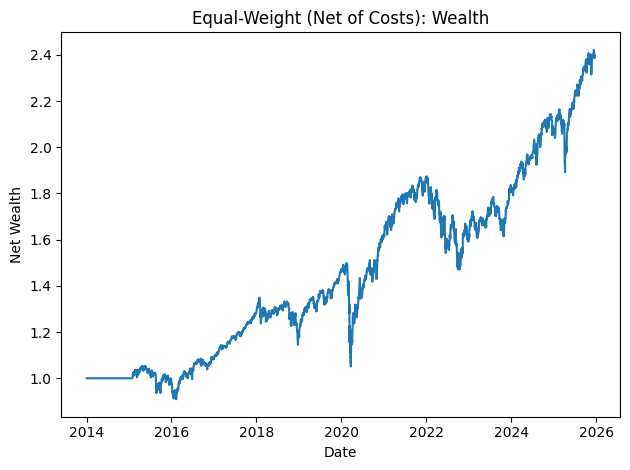

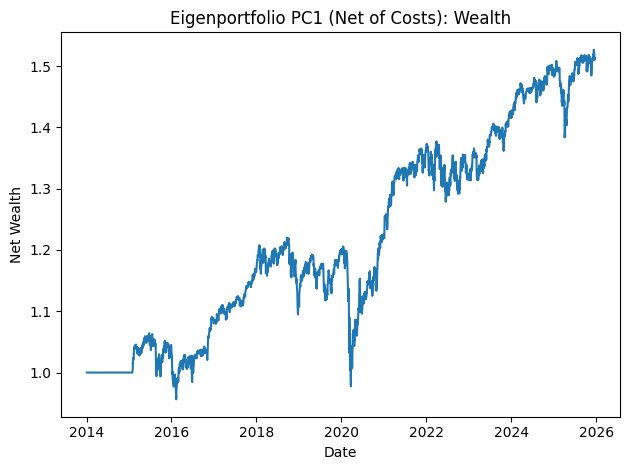

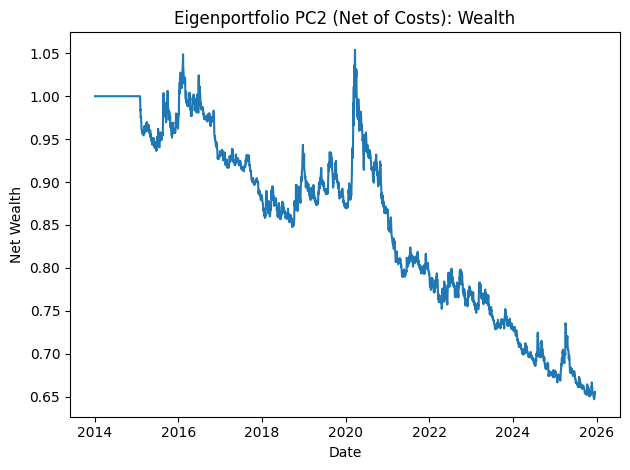

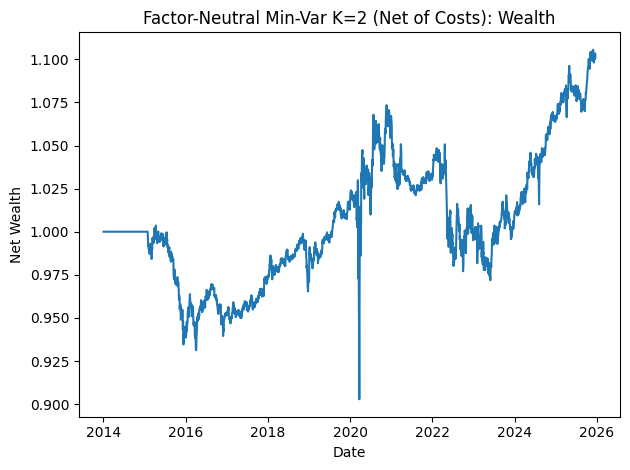

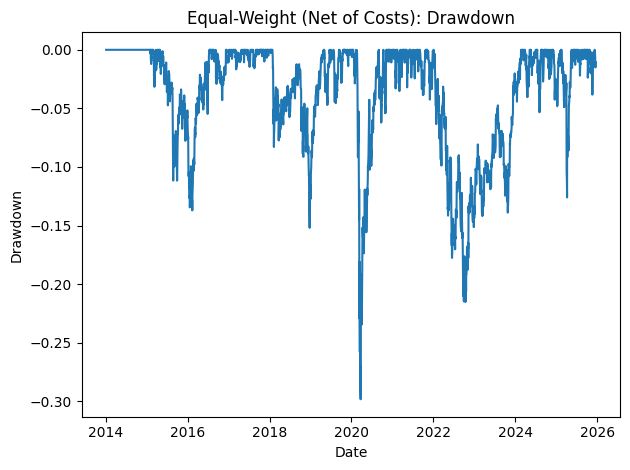

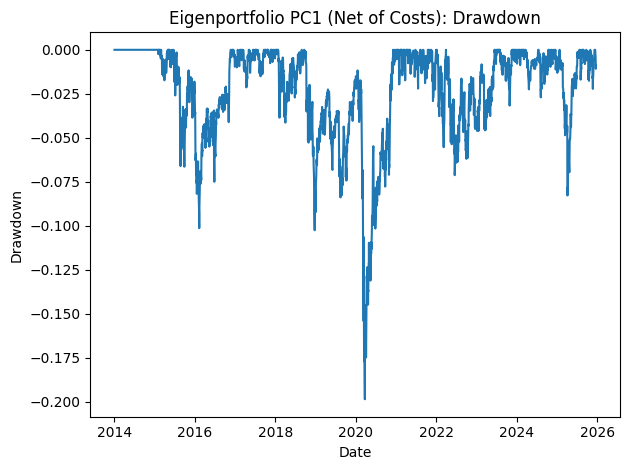

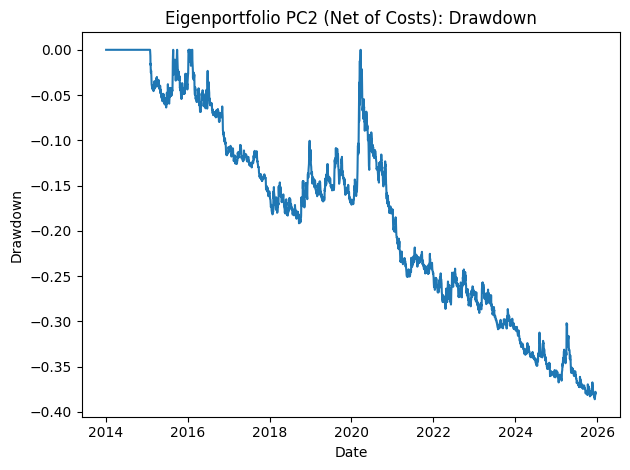

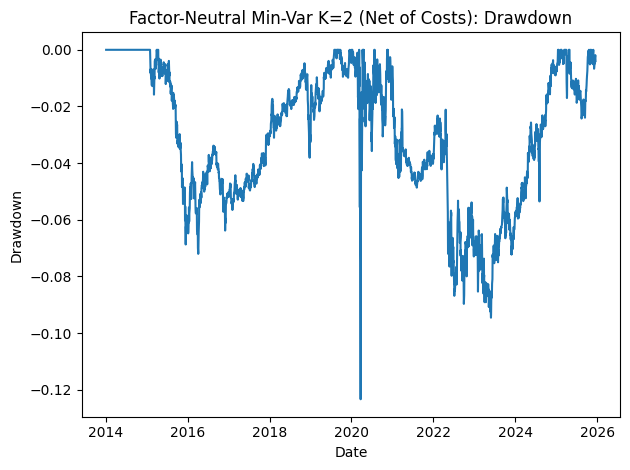

In [10]:
import matplotlib.pyplot as plt

def plot_wealth(bt, title, filename):
    plt.figure()
    plt.plot(bt["wealth_net"])
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Net Wealth")
    plt.tight_layout()
    plt.savefig(f"figures/{filename}")
    plt.show()

def plot_drawdown(bt, title, filename):
    w = bt["wealth_net"]
    dd = w / w.cummax() - 1
    plt.figure()
    plt.plot(dd)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.tight_layout()
    plt.savefig(f"figures/{filename}")
    plt.show()

plot_wealth(bt_eq, "Equal-Weight (Net of Costs): Wealth", "week3_wealth_eq.png")
plot_wealth(bt_pc1, "Eigenportfolio PC1 (Net of Costs): Wealth", "week3_wealth_pc1.png")
plot_wealth(bt_pc2, "Eigenportfolio PC2 (Net of Costs): Wealth", "week3_wealth_pc2.png")
plot_wealth(bt_fnmv, "Factor-Neutral Min-Var K=2 (Net of Costs): Wealth", "week3_wealth_fnmv.png")

plot_drawdown(bt_eq, "Equal-Weight (Net of Costs): Drawdown", "week3_dd_eq.png")
plot_drawdown(bt_pc1, "Eigenportfolio PC1 (Net of Costs): Drawdown", "week3_dd_pc1.png")
plot_drawdown(bt_pc2, "Eigenportfolio PC2 (Net of Costs): Drawdown", "week3_dd_pc2.png")
plot_drawdown(bt_fnmv, "Factor-Neutral Min-Var K=2 (Net of Costs): Drawdown", "week3_dd_fnmv.png")
